<a href="https://colab.research.google.com/github/jombraga/EE-298---Deep-Learning/blob/master/Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#Get files from Darwin's GitHub
! git clone https://github.com/baudm/ee298z.git

fatal: destination path 'ee298z' already exists and is not an empty directory.


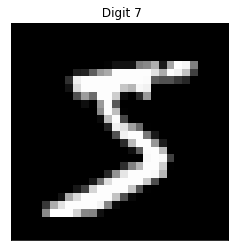

In [27]:
'''Trains a denoising autoencoder on MNIST dataset.
Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.
Noise + Data ---> Denoising Autoencoder ---> Data
Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.
This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function

from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, UpSampling2D

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ee298z.hw2.transforms import corrupt_mnist_copy
from ee298z.hw2.benchmark_keras import test_model

np.random.seed(1337)

# load MNIST dataset
(x_train, y_train), (x_test, y_train) = mnist.load_data()

#Corrupt the image
x_train_corrupted = corrupt_mnist_copy(x_train)
x_test_corrupted = corrupt_mnist_copy(x_test)

#Show five original images and corrupted images

#1st original
%matplotlib inline
plt.imshow(x_train[0])
plt.title(" Digit " + str(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.gray()

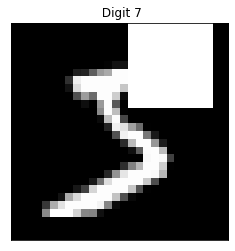

In [28]:
#1st corrupted
%matplotlib inline
plt.imshow(x_train_corrupted[0])
plt.title(" Digit " + str(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.gray()


<function matplotlib.pyplot.gray>

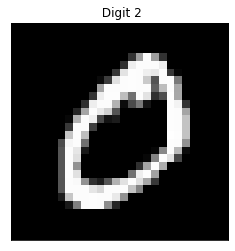

In [29]:
#2nd original
%matplotlib inline
plt.imshow(x_train[1])
plt.title(" Digit " + str(y_train[1]))
plt.xticks([])
plt.yticks([])
plt.gray

<function matplotlib.pyplot.gray>

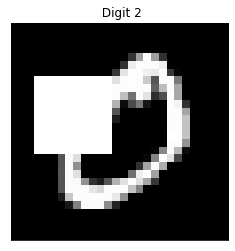

In [30]:
#2nd corrupted
%matplotlib inline
plt.imshow(x_train_corrupted[1])
plt.title(" Digit " + str(y_train[1]))
plt.xticks([])
plt.yticks([])
plt.gray

<function matplotlib.pyplot.gray>

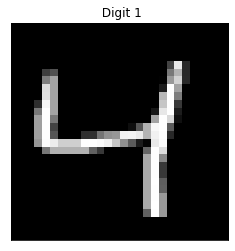

In [31]:
#3rd original
%matplotlib inline
plt.imshow(x_train[2])
plt.title(" Digit " + str(y_train[2]))
plt.xticks([])
plt.yticks([])
plt.gray

<function matplotlib.pyplot.gray>

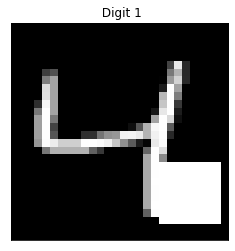

In [32]:
#3rd corrupted
%matplotlib inline
plt.imshow(x_train_corrupted[2])
plt.title(" Digit " + str(y_train[2]))
plt.xticks([])
plt.yticks([])
plt.gray

<function matplotlib.pyplot.gray>

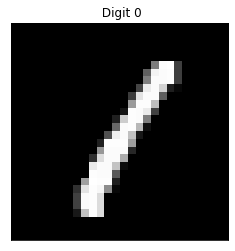

In [33]:
#4th original
%matplotlib inline
plt.imshow(x_train[3])
plt.title(" Digit " + str(y_train[3]))
plt.xticks([])
plt.yticks([])
plt.gray

<function matplotlib.pyplot.gray>

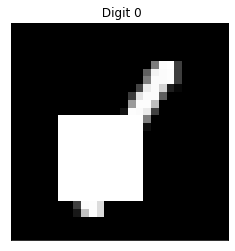

In [34]:
#4th corrupted
%matplotlib inline
plt.imshow(x_train_corrupted[3])
plt.title(" Digit " + str(y_train[3]))
plt.xticks([])
plt.yticks([])
plt.gray

<function matplotlib.pyplot.gray>

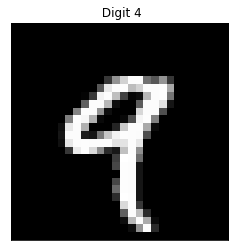

In [35]:
#5th original
%matplotlib inline
plt.imshow(x_train[4])
plt.title(" Digit " + str(y_train[4]))
plt.xticks([])
plt.yticks([])
plt.gray

<function matplotlib.pyplot.gray>

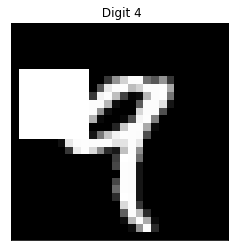

In [36]:
#5th corrupted
%matplotlib inline
plt.imshow(x_train_corrupted[4])
plt.title(" Digit " + str(y_train[4]))
plt.xticks([])
plt.yticks([])
plt.gray

In [0]:
#Scale to [0,1]
image_size = x_train_corrupted.shape[1]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_train/255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32')
x_test/=255



In [38]:
x_train_corrupted = x_train_corrupted.reshape(x_train_corrupted.shape[0], 28, 28, 1)
x_train = x_train.astype(K.floatx())/255.
x_train_corrupted = x_train_corrupted.astype(K.floatx())/255.

x_test_corrupted= x_test_corrupted.reshape(x_test_corrupted.shape[0],28,28,1)
x_test_corrupted = x_test_corrupted.astype(K.floatx())/255.

print(x_train_corrupted.shape)
print(x_test_corrupted.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

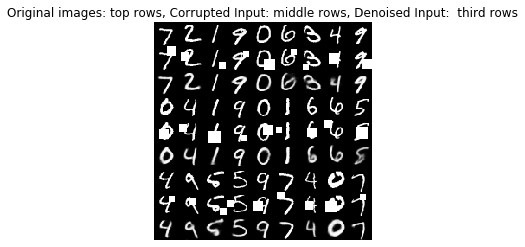

In [39]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_corrupted,
                x_train,
                validation_data=(x_test_corrupted, x_test),
                epochs=10,
                batch_size=batch_size)

# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_corrupted)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_corrupted[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

In [40]:
#Benchmarking

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale to [0, 1]
x_test = x_test.astype(K.floatx()) / 255.

# model is your Keras model
# DO NOT convert y_test, i.e. don't use keras.utils.to_categorical()
test_model(autoencoder, x_test, y_test, batch_size=100)

Classifier score: 93.99
SSIM score: 89.64
